### Population parameter inference based on sub-threshold sources (from maps)

\begin{equation}
    {\color{orange} {r_3(\boldsymbol{\vartheta}; \boldsymbol{x}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)}} \equiv
     \frac{
     p(\boldsymbol{\vartheta}|\boldsymbol{x}, \mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)
     }{
     p(\boldsymbol{\vartheta}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)
     }
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import sims
from utils import detect_peaks
from networks import NetworkMaps, NetworkSensitivity, NetworkParamMap

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

### Simulate with bounds

Load back model for r_2

In [3]:
simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original_d.zarr")

def hook(out):
    N = int(out['pdp'][0])
    idx = torch.randint(N, (1,)) # index in simulated source range
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    # make sure to pick source simulated in image
    while torch.sum((out['source'][:2]>40)+(out['source'][:2]<-40), -1):
        idx = torch.randint(N, (1,)) # index in simulated source range
        out['source'] = torch.from_numpy(out['pdc'][idx]) # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    out['d_source'] = np.array([out['d'][idx]])*1. # (1,)   
    out = sl.to_numpy32(out)
    return out

dl_test = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample=hook)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_sensitivity/version_0/checkpoints/model.yaml")
network_d = NetworkSensitivity()
trainer.test(network_d, dl_test, ckpt_path = ckpt_path);

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.010898170061409473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


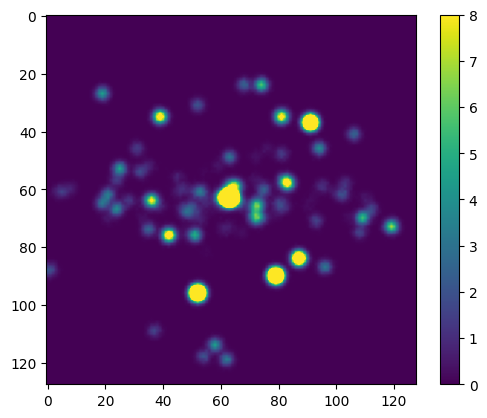

In [4]:
threshold = 5
psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = threshold)
simulator = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)

plt.imshow(simulator.sample()['data'], vmax = 8)
plt.colorbar();

In [5]:
shapes, dtypes = simulator.get_shapes_and_dtypes()
zs = swyft.ZarrStore(f"/project/fermi_data/neurips_bounded.zarr").init(50000, 64, shapes, dtypes)
zs.simulate(simulator, batch_size = 500)

### Load back network for point sources detection

Resample noise and PSF

In [6]:
from scipy.ndimage import gaussian_filter

def hook(out):
    out['mu'] =  gaussian_filter(out['mu_psc'], 1.5)*4   # resample psf
    out['data'] = np.random.poisson(out['mu']*100)/100  # resample noise
    out = sl.to_numpy32(out)
    return out


dl_train = zs.get_dataloader(idx_range = [0, 36000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)
dl_val = zs.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)

In [7]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu')
network_maps = NetworkMaps()
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_detection/version_0/checkpoints/model.yaml")
print(ckpt_path)
trainer.test(network_maps, dl_val, ckpt_path = ckpt_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Restoring states from the checkpoint path at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -925.7904052734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -925.7904052734375}]

### Test peaks routine and counts distribution

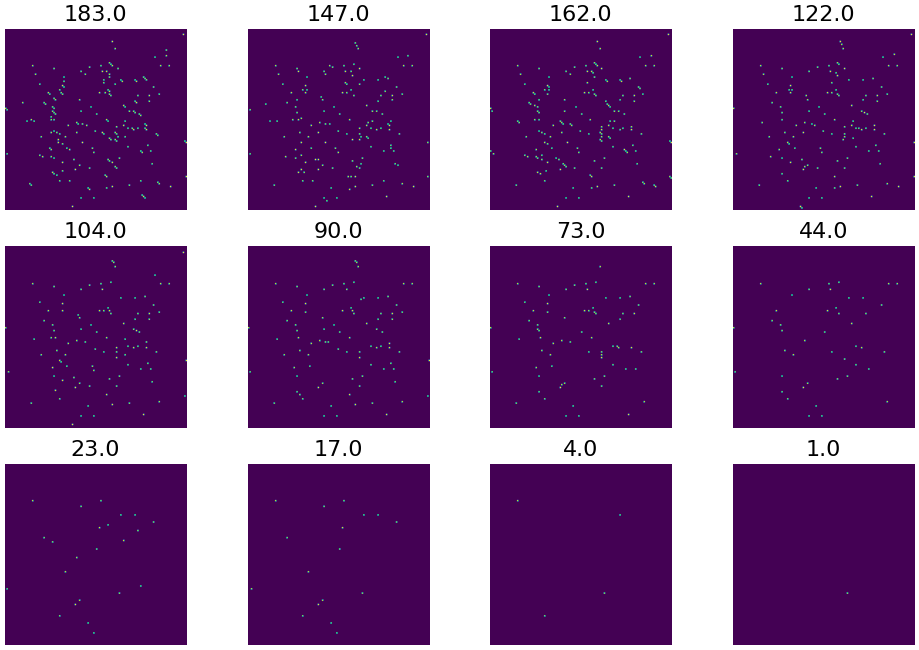

In [8]:
# observation 
s0 = np.load('obs.npy', allow_pickle=True).item()
data = torch.tensor(s0['data']).unsqueeze(0)
pdcc = torch.tensor(s0['pdcc']).unsqueeze(0)
samples = swyft.Samples(data=data, pdcc=pdcc)
maps = network_maps(samples, samples)['aux_psc'].detach().clone()
maps[maps < 1e-10] = 0
maps = torch.movedim(maps, -1, -3)
peaks = detect_peaks(maps)
counts_obs = peaks.sum((-2, -1))

plt.style.use(['science', 'notebook'])
plt.figure(figsize=(12, 8))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    im = ax.imshow(peaks[0, i])
    plt.axis('off')
    ax.set_title(f"{counts_obs[0][i]}")
#     plt.colorbar(im, ax=ax)

In [9]:
# samples from targeted store 
N = 100
simulator_t = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)
samples_t = simulator_t.sample(N)
data_t = torch.tensor(samples_t['data'])
pdcc_t = torch.tensor(samples_t['pdcc'])
# pdcc_t = torch.tensor(zs['pdcc'][:N])
# data_t = torch.tensor(zs['data'][:N])
samples_t = swyft.Samples(data=data_t, pdcc=pdcc_t)
maps_t = network_maps(samples_t, samples_t)['aux_psc'].detach().clone()
maps_t[maps_t < 1e-10] = 0
maps_t = torch.movedim(maps_t, -1, -3)
peaks_t = detect_peaks(maps_t)
counts_t = peaks_t.sum((-2, -1))

# samples from targeted store conditioned on observation hyperparameters 
simulator_pdp = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)
samples_pdp = simulator_pdp.sample(N, conditions={'pdp': s0['pdp']})
data_pdp = torch.tensor(samples_pdp['data'])
pdcc_pdp = torch.tensor(samples_pdp['pdcc'])
samples_pdp = swyft.Samples(data=data_pdp, pdcc=pdcc_pdp)
maps_pdp = network_maps(samples_pdp, samples_pdp)['aux_psc'].detach().clone()
maps_pdp[maps_pdp < 1e-10] = 0
maps_pdp = torch.movedim(maps_pdp, -1, -3)
peaks_pdp = detect_peaks(maps_pdp)
counts_pdp = peaks_pdp.sum((-2, -1))

# samples from original store conditioned on observation hyperparameters 
simulator_or = sims.ToyFermi(npix = 128)
samples_or = simulator_or.sample(N, conditions={'pdp': s0['pdp']})
data_or = torch.tensor(samples_or['data'])
pdcc_or = torch.tensor(samples_or['pdcc'])
samples_or = swyft.Samples(data=data_or, pdcc=pdcc_or)
maps_or = network_maps(samples_or, samples_or)['aux_psc'].detach().clone()
maps_or[maps_or < 1e-10] = 0
maps_or = torch.movedim(maps_or, -1, -3)
peaks_or = detect_peaks(maps_or)
counts_or = peaks_or.sum((-2, -1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 532.55it/s]


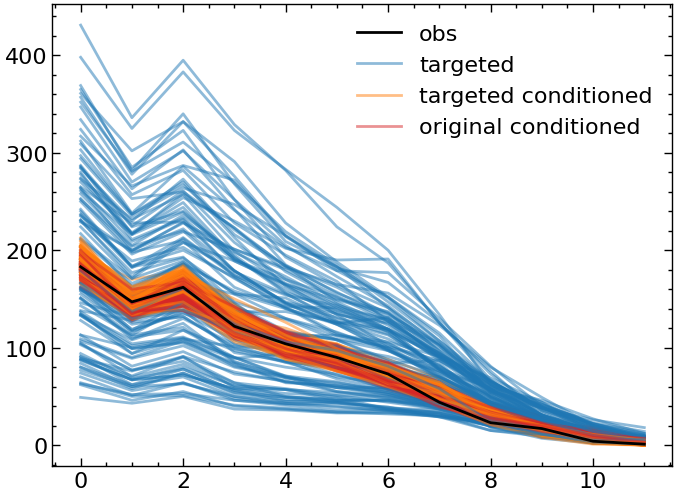

In [10]:
for i in range(N):
    plt.plot(counts_t[i], c='tab:blue', alpha=0.5);
    plt.plot(counts_pdp[i], c='tab:orange', alpha=0.5);
    plt.plot(counts_or[i], c='tab:red', alpha=0.5);
plt.plot(counts_obs[0], c='k', label='obs')
plt.plot([], c='tab:blue', alpha=0.5, label='targeted')
plt.plot([], c='tab:orange', alpha=0.5, label='targeted conditioned')
plt.plot([], c='tab:red', alpha=0.5, label='original conditioned')
plt.legend();

### Train for population hyperparameters using peaks maps

Network for hparams inference using maps from previously trained posint source detection network

In [11]:
logger = TensorBoardLogger("./lightning_logs", name = 'neurips_params_map', version=None)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", save_top_k=1, mode="min",)

trainer = swyft.SwyftTrainer(
    accelerator = 'gpu', 
    gpus=1, 
    max_epochs = 100, 
    logger = logger, 
    callbacks = [checkpoint_callback]
)

network_param_map = NetworkParamMap(
    lr=1e-3, lrs_factor = 0.1, lrs_patience = 3, early_stopping_patience = 5,
    network_maps=network_maps
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
# trainer.fit(network_param_map, train_dataloaders = dl_train, val_dataloaders = dl_val)

Missing logger folder: ./lightning_logs/neurips_params_map
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                   | Params
----------------------------------------------------
0 | maps     | NetworkMaps            | 20.2 K
1 | re_data  | LogRatioEstimator_1dim | 54.3 K
2 | re_data2 | LogRatioEstimator_Ndim | 54.5 K
----------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.516     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
# checkpoint_callback.to_yaml(checkpoint_callback.dirpath+"/model.yaml")
# ckpt_path = swyft.best_from_yaml(checkpoint_callback.dirpath+"/model.yaml")
ckpt_path = swyft.best_from_yaml(f"./lightning_logs/neurips_params_map/version_0/checkpoints"+"/model.yaml")

print(ckpt_path)
trainer.test(network_param_map, dl_val, ckpt_path = ckpt_path)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
Restoring states from the checkpoint path at ./lightning_logs/neurips_params_map/version_0/checkpoints/epoch=16-val_loss=-4.71.ckpt


./lightning_logs/neurips_params_map/version_0/checkpoints/epoch=16-val_loss=-4.71.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_params_map/version_0/checkpoints/epoch=16-val_loss=-4.71.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -4.653652667999268
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -4.653652667999268}]

### Inference

In [14]:
s0 = np.load('obs.npy', allow_pickle=True).item()
# s0 = zs[28]

In [15]:
truth = {f'pdp[{i}]': s0['pdp'][i] for i in range(3)}
labeler = {'pdp[0]': r"N", 'pdp[1]': r"$\sigma_\mathrm{flux}$", 'pdp[2]': "h"}
B = simulator.sample(10000, targets=['pdcc'])
A = swyft.Sample(s0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.15it/s]


In [16]:
out = trainer.infer(network_param_map, A, B)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1126it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


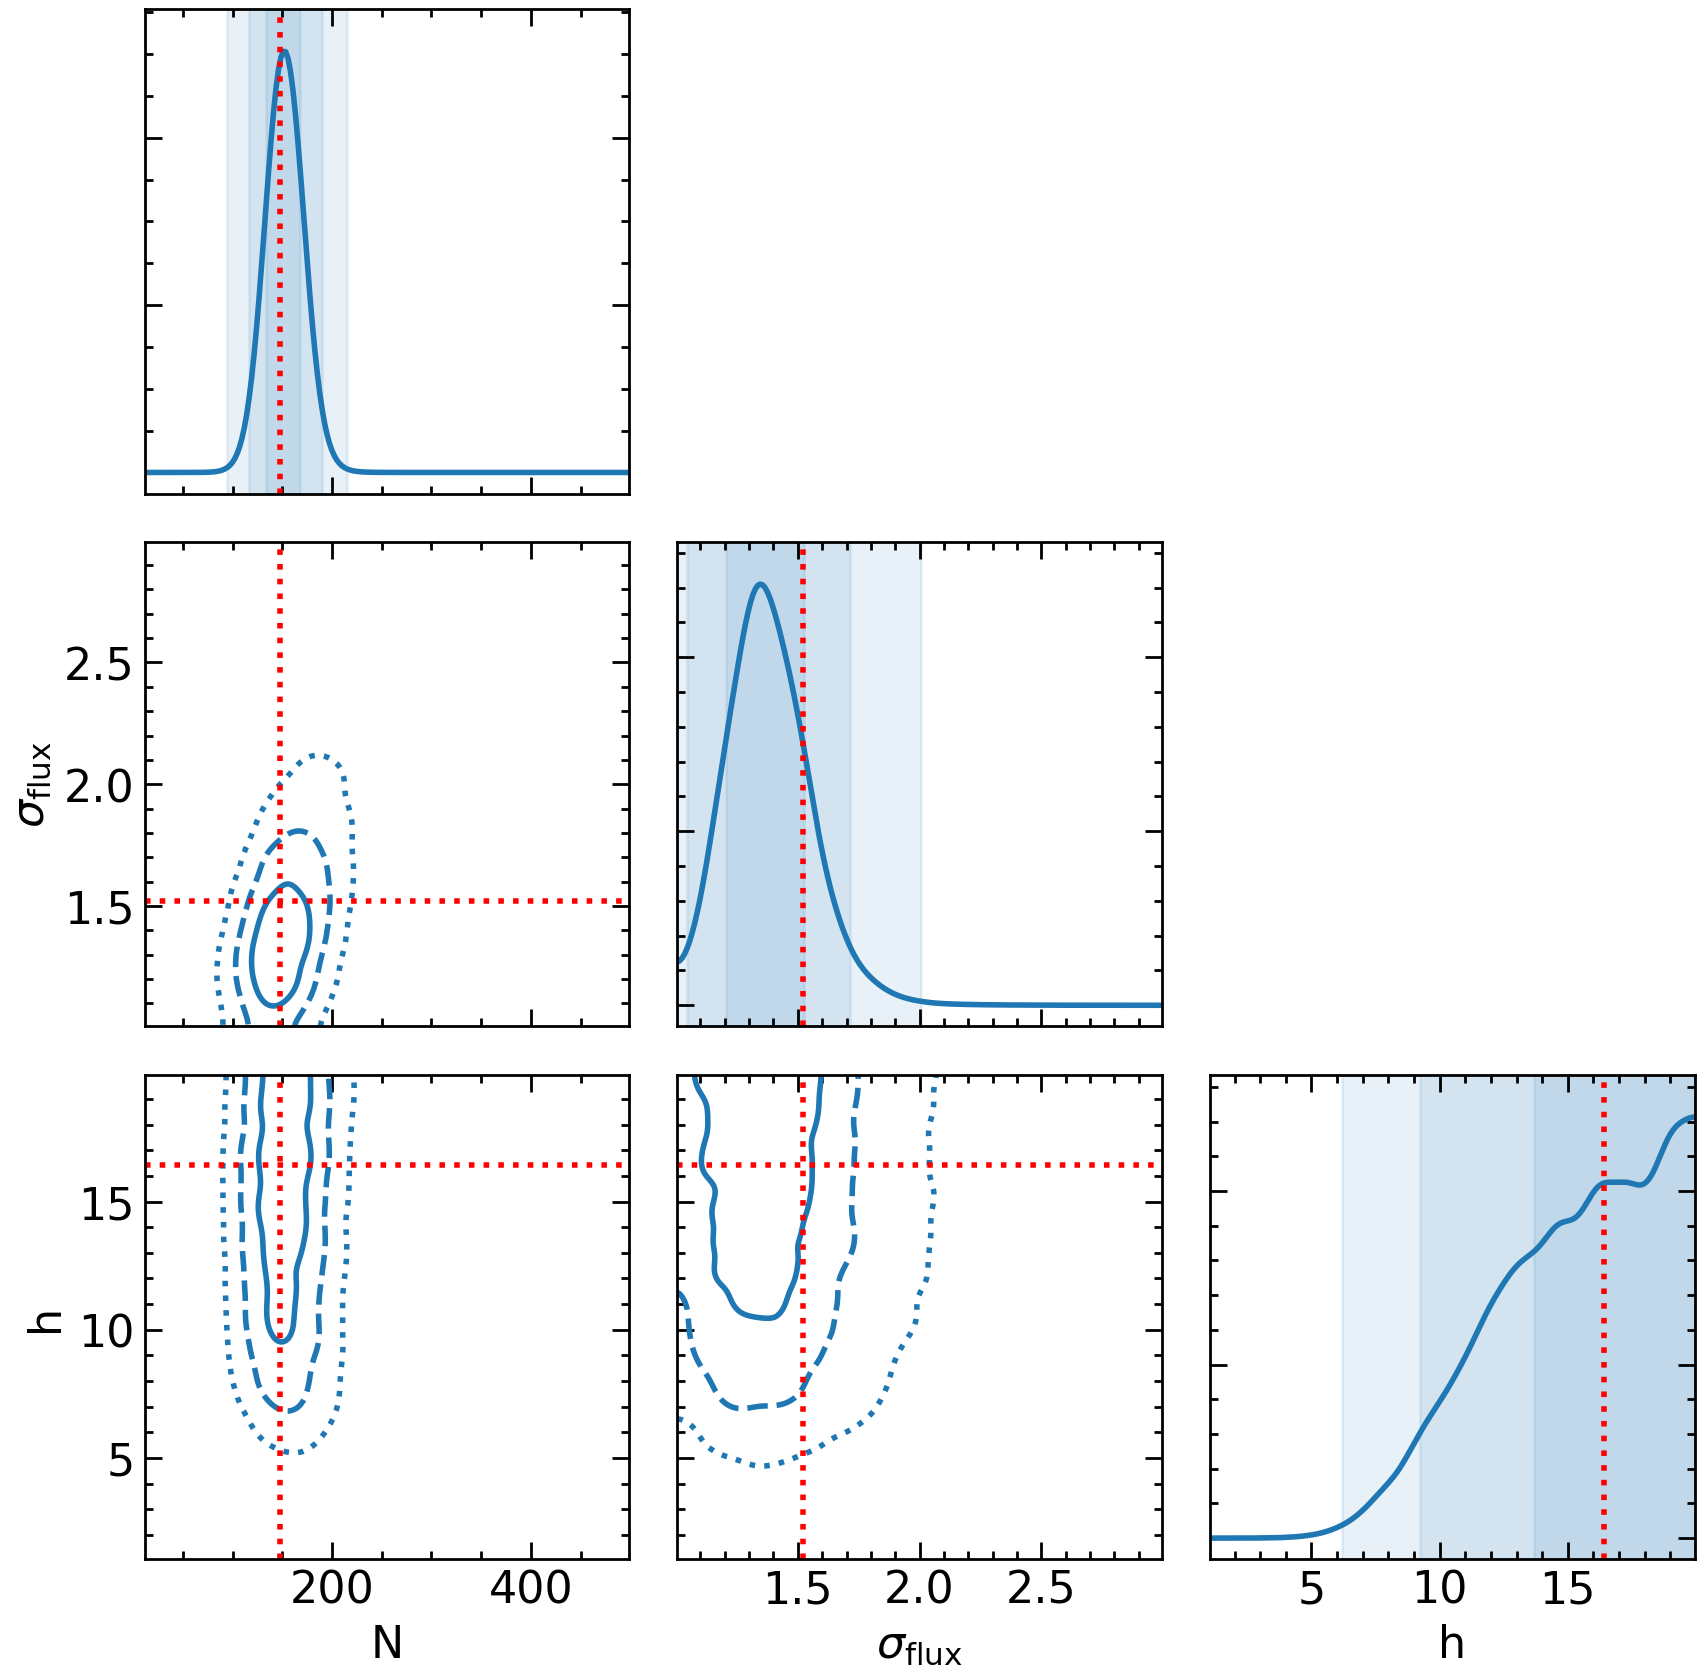

In [17]:
# bounded pdp th=5
swyft.corner((out['re_param'],out['re_param2'],), ('pdp[0]', 'pdp[1]', 'pdp[2]'), 
             truth=truth, labeler=labeler, 
             bins = 200, smooth = 5, color='tab:blue');

### Test

In [18]:
pdcc = zs['pdcc'][-1000:]
pdcr = zs['pdcr'][-1000:]
pdp = zs['pdp'][-1000:]
data = zs['data'][-1000:]

samples = swyft.Samples(data=data, pdp=pdp, pdcc=pdcc, pdcr=pdcr)

In [19]:
coverage_samples = trainer.test_coverage(network_param_map, samples, B)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1126it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1126it [00:00, ?it/s]

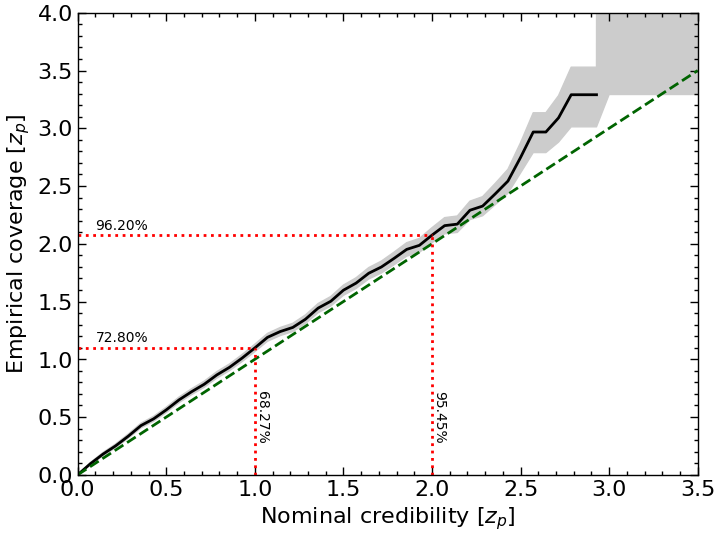

In [20]:
swyft.plot_zz(coverage_samples, 'pdp[0]')

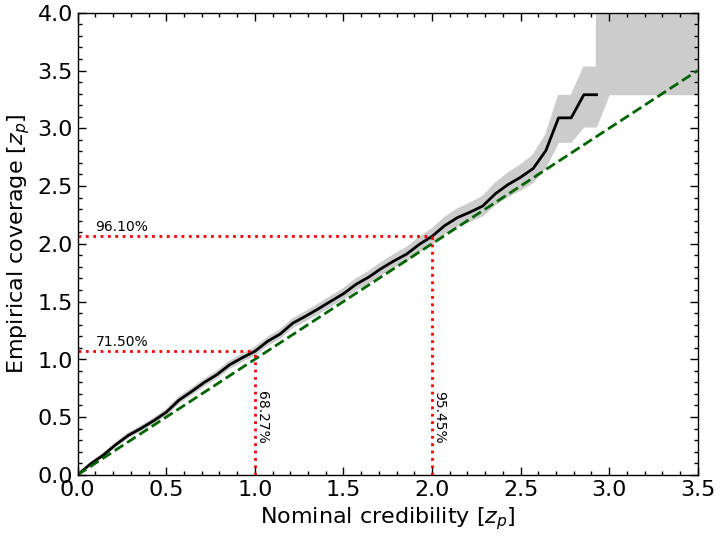

In [21]:
swyft.plot_zz(coverage_samples, 'pdp[1]')

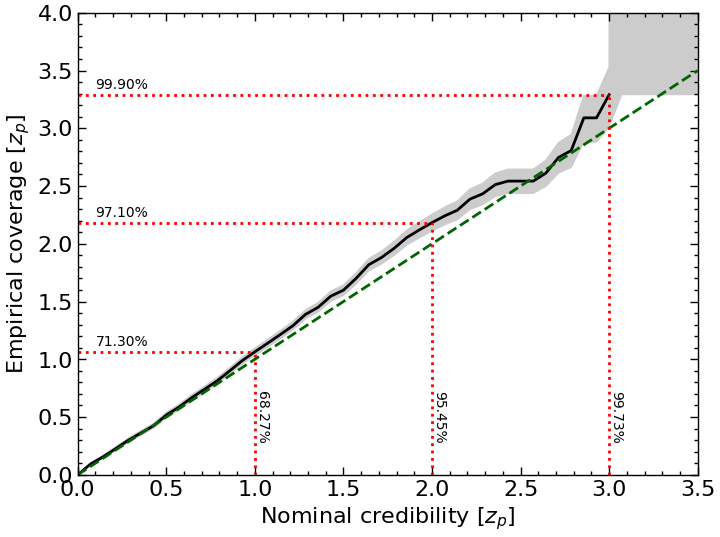

In [22]:
swyft.plot_zz(coverage_samples, 'pdp[2]')

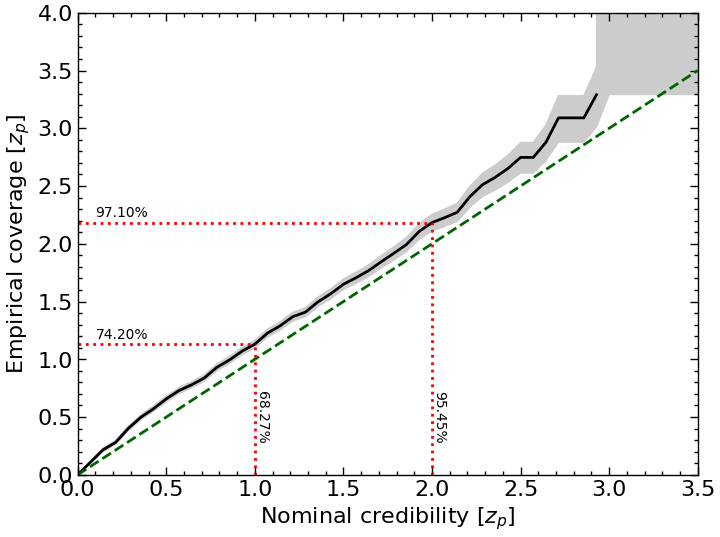

In [23]:
swyft.plot_zz(coverage_samples, 'pdp[0]', 'pdp[1]')

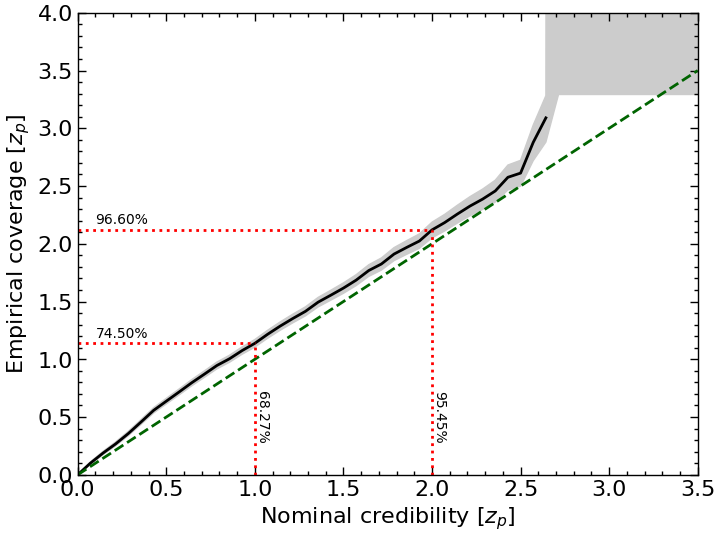

In [24]:
swyft.plot_zz(coverage_samples, 'pdp[0]', 'pdp[2]')

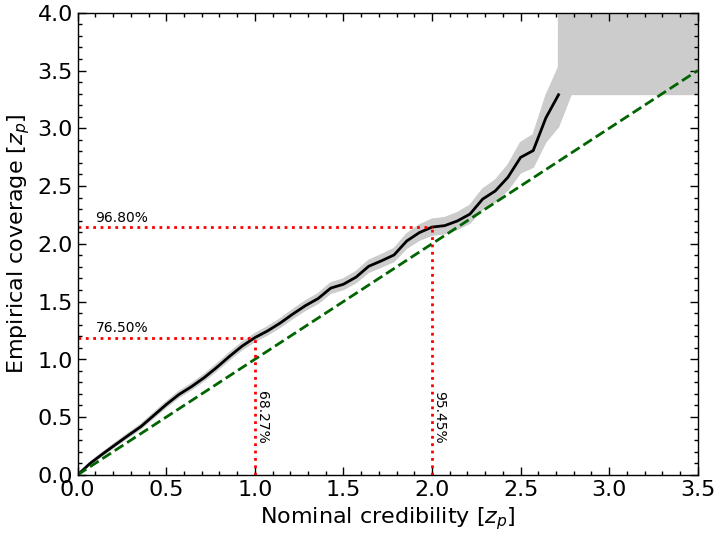

In [25]:
swyft.plot_zz(coverage_samples, 'pdp[1]', 'pdp[2]')